# XAI4HEAT Demo Notebook

This notebook demonstrates the functionality of the XAI4HEAT package for heat load forecasting, anomaly detection, and explainability in district heating systems.

## Setup and Imports

In [206]:
# Enable autoreload to automatically reload modules when they change
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Suppress PerformanceWarning
import warnings
from pandas.errors import PerformanceWarning

warnings.simplefilter(action='ignore', category=PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)


# Import xai4heat package
import xai4heat
from xai4heat import data, forecasting, xai

print(f"XAI4HEAT version: {xai4heat.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
XAI4HEAT version: 0.1.0


In [253]:
import platform
import psutil
import subprocess
import torch

# System information
print("=" * 60)
print("SYSTEM INFORMATION")
print("=" * 60)
print(f"OS: {platform.system()} {platform.release()}")
print(f"Architecture: {platform.machine()}")
print(f"Processor: {platform.processor()}")
print(f"Python Version: {platform.python_version()}")

# CPU information
print("\n" + "=" * 60)
print("CPU INFORMATION")
print("=" * 60)
print(f"Physical cores: {psutil.cpu_count(logical=False)}")
print(f"Total cores (with hyperthreading): {psutil.cpu_count(logical=True)}")
print(f"Max CPU frequency: {psutil.cpu_freq().max:.2f} MHz" if psutil.cpu_freq() else "CPU frequency: N/A")

# Memory information
print("\n" + "=" * 60)
print("MEMORY INFORMATION")
print("=" * 60)
mem = psutil.virtual_memory()
print(f"Total RAM: {mem.total / (1024**3):.2f} GB")
print(f"Available RAM: {mem.available / (1024**3):.2f} GB")
print(f"Used RAM: {mem.used / (1024**3):.2f} GB ({mem.percent}%)")

# GPU information
print("\n" + "=" * 60)
print("GPU INFORMATION")
print("=" * 60)
try:
    if torch.cuda.is_available():
        print(f"CUDA available: Yes")
        print(f"CUDA version: {torch.version.cuda}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
            print(f"    Memory: {torch.cuda.get_device_properties(i).total_memory / (1024**3):.2f} GB")
    else:
        print("CUDA available: No (CPU only)")
except ImportError:
    print("PyTorch not installed - cannot check GPU")

# Disk information
print("\n" + "=" * 60)
print("DISK INFORMATION")
print("=" * 60)
disk = psutil.disk_usage('/')
print(f"Total disk space: {disk.total / (1024**3):.2f} GB")
print(f"Used disk space: {disk.used / (1024**3):.2f} GB")
print(f"Free disk space: {disk.free / (1024**3):.2f} GB ({100 - disk.percent}%)")

print("\n" + "=" * 60)

SYSTEM INFORMATION
OS: Windows 11
Architecture: AMD64
Processor: AMD64 Family 25 Model 97 Stepping 2, AuthenticAMD
Python Version: 3.12.8

CPU INFORMATION
Physical cores: 8
Total cores (with hyperthreading): 16
Max CPU frequency: 3601.00 MHz

MEMORY INFORMATION
Total RAM: 31.19 GB
Available RAM: 7.81 GB
Used RAM: 23.38 GB (75.0%)

GPU INFORMATION
CUDA available: No (CPU only)

DISK INFORMATION
Total disk space: 952.92 GB
Used disk space: 378.76 GB
Free disk space: 574.16 GB (60.3%)



All computational experiments were conducted on a Windows 11 laptop equipped with an AMD64 architecture processor (Family 25 Model 97) comprising 8 physical cores and 16 logical cores (hyperthreading enabled), with a maximum clock frequency of 3.6 GHz. No GPU acceleration was used; all computations, including XGBoost and LightGBM training as well as Hyperopt-based Bayesian optimization, were executed in CPU-only mode utilizing multi-threaded parallelism.

## 1. Data Module

Functions for data loading and preprocessing

In [254]:
# Test data module functions here

substations=['L4', 'L8', 'L12', 'L17', 'L22']

df=data.get_scada_data('L4',
                 True,
                 True,
                 interpolate='model',
                 handle_outliers=True,
                 handle_outliers_contamination=0.005
                 )

Timeline (from/to):  2019-08-05 13:00:00 2025-05-01 23:45:00
Detecting and removing outliers with contamination=0.005
Number of outliers detected: 113
Replaced 113 outlier timestamps with NaN in ['qizm', 't_sup_prim', 't_ret_prim', 't_sup_sec', 't_ret_sec']


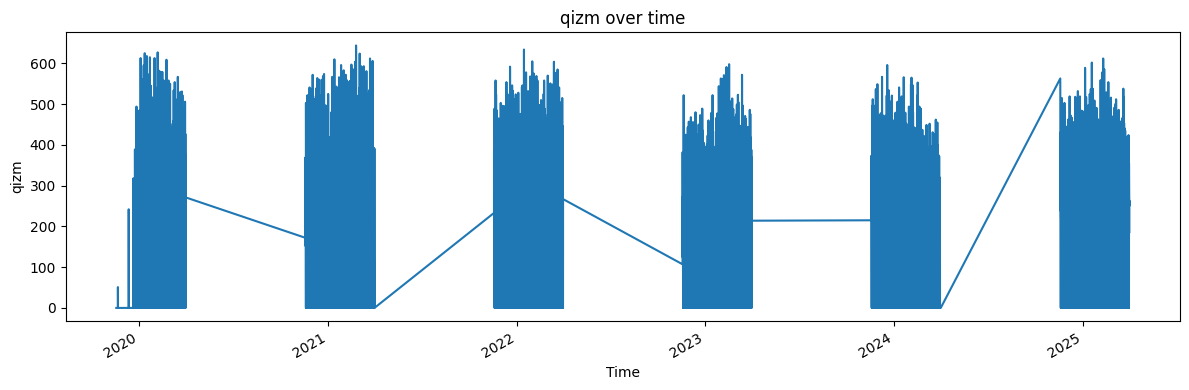

In [255]:
plt.figure(figsize=(12, 4))
df['qizm'].plot()
plt.title("qizm over time")
plt.xlabel("Time")
plt.ylabel("qizm")
plt.tight_layout()

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12860 entries, 2021-11-18 06:00:00 to 2025-03-31 22:00:00
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t_amb             12860 non-null  float64
 1   t_sup_prim        12860 non-null  float64
 2   t_ret_prim        12860 non-null  float64
 3   t_sup_sec         12860 non-null  float64
 4   t_ret_sec         12860 non-null  float64
 5   qizm              12860 non-null  float64
 6   temp              12860 non-null  float64
 7   humidity          12860 non-null  float64
 8   windspeed         12860 non-null  float64
 9   sealevelpressure  12860 non-null  float64
 10  hour_of_day       12860 non-null  int32  
 11  heating_on        12860 non-null  int64  
 12  delta_primary     12860 non-null  float64
 13  delta_secondary   12860 non-null  float64
 14  sin_hour          12860 non-null  float64
 15  cos_hour          12860 non-null  float64
 16  seaso

In [146]:
outliers_df = data.get_outliers_isolation_forest(df, contamination=0.0005, verbose=True)


# Create the interactive plot
fig = data.plot_signals_with_outliers(df, outliers_df)
fig.show()

Number of outliers detected: 8


## Missing data imputation approach

Missing data were handled using a hierarchical, model-assisted imputation approach. First, meteorological data was used to reconstruct the missing ambient temperature signal, acquired at the substation level. Whenever the local outdoor sensor value was unavailable, it was estimated from the nearby weather-station temperature using a regularized linear regression model trained exclusively on time steps where both measurements were present.

For hydraulic temperatures on the primary and secondary circuits (t_sup_prim, t_ret_prim, t_sup_sec, t_ret_sec), a set of gradient-boosted decision tree models (LightGBM) was employed. Separate regressors were trained for each variable using only information available at the same or earlier timestamps. The predictors included the ambient temperature, the remaining circuit temperatures and autoregressive lag features. Because several temperatures may be missing simultaneously, the procedure was executed iteratively: after each prediction round, newly reconstructed values were re-introduced into the feature space and lagged predictors were recomputed.

Missing hourly transmitted energy (qizm) data was reconstructed using a similar LightGBM model driven by the thermal state of both circuits, ambient conditions, temperature differences across supply and return lines, and historical energy lags.

## Outliers detection approach

The applied outlier detection approach was two-fold, by considering measurement and operational anomalies. First, negative and extremely large values of transmitted energy were found (inaccurate readings from the calorimeter sensors on primary and secondary circuits, due to sensor malfunction and communication loss), replaced with missing values and imputed by using the model-based approach. Second, operational anomalies, namely the DHS operator decisions that deviate from optimal or expected control logic are looked for. Examples of the operational anomalies are extreme morning peaks when the heating is switched on too late, overheating during mild weather and others.

We look for operational anomalies in multivariate space (ambient temperature, demand). To avoid detection of daily cycle peaks as anomalies, in our approach we detect anomalies on the number of datasets, for which data included only transmitted energy and ambient temperature at the given hour. In this work, Isolation Forest algorithm was used for multivariate outlier detection (with very conservative contamination), as it was earlier found as the most accurate in detecting operational errors (Turudija et al).

It is important to highlight that operational outliers are not statistical outliers in the classical sense. They are control-policy deviations, represented in data by the deviations from expected thermodynamic relationship between ambient temperature and transmitted energy. The approach of detecting and replacing those datapoints with model-based imputed ones is particularly appropriate for forecasting applications, as it preserves realistic intermittency patterns and maintains the physical plausibility of the reconstructed heat-demand signal.

Loading data for substation L4...
Loading data for substation L8...
Filtered L12, L22, and L8 data to only include timestamps from October 8th, 2021 onwards due to data quality issues before that date.
Loading data for substation L12...
Filtered L12, L22, and L8 data to only include timestamps from October 8th, 2021 onwards due to data quality issues before that date.
Loading data for substation L17...
Loading data for substation L22...
Filtered L12, L22, and L8 data to only include timestamps from October 8th, 2021 onwards due to data quality issues before that date.


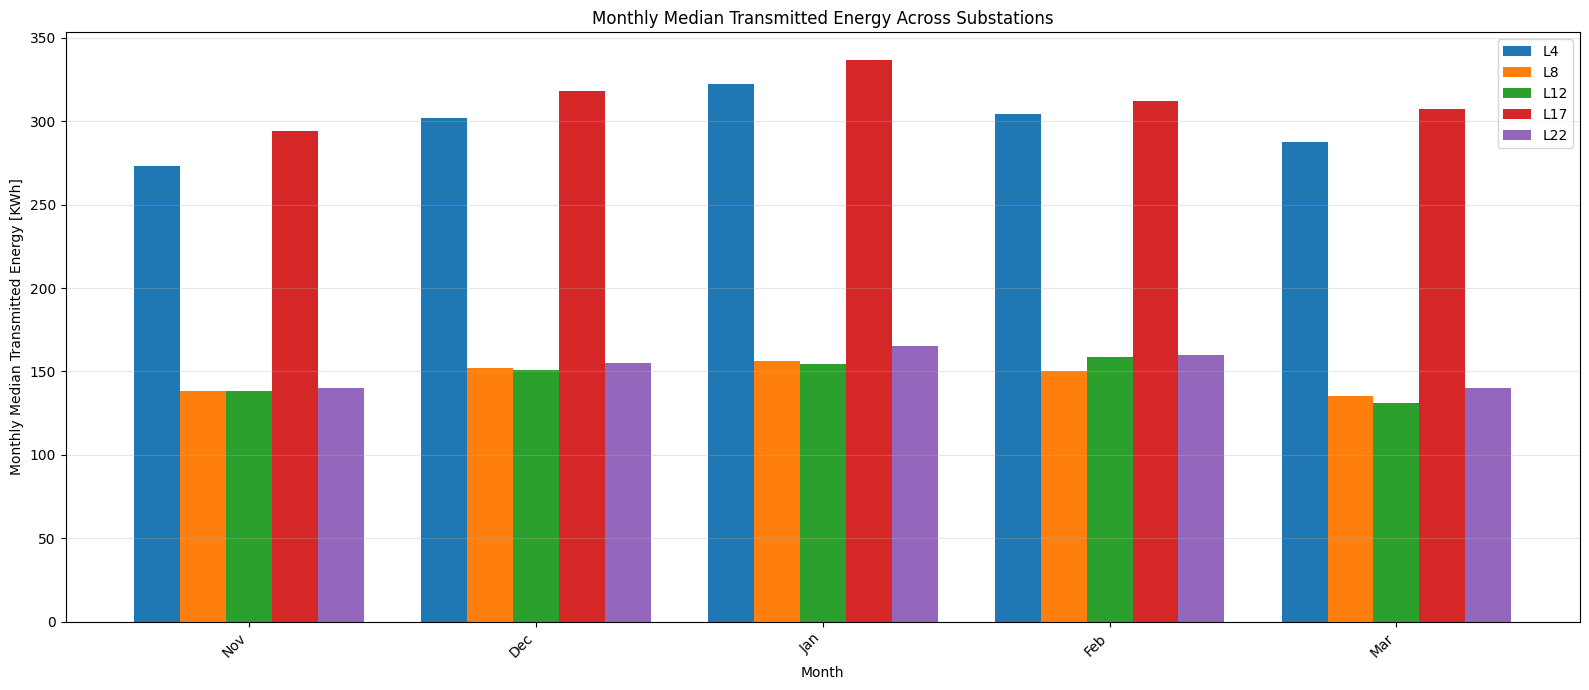

In [226]:
substations_heated_area={'L4': 9134.96, 'L8': 3800.69, 'L12': 4170.98, 'L17': 9128.1, 'L22': 5103.59}


fig, ax = data.plot_monthly_median_energy_comparison(
    substations=list(substations_heated_area.keys()),
    interpolate='model',
    handle_outliers=True,
    handle_outliers_contamination=0.005,
    verbose=True,
    figsize=(16, 7)
)
plt.show()

Loading data for substation L4...
Loading data for substation L8...
Filtered L12, L22, and L8 data to only include timestamps from October 8th, 2021 onwards due to data quality issues before that date.
Loading data for substation L12...
Filtered L12, L22, and L8 data to only include timestamps from October 8th, 2021 onwards due to data quality issues before that date.
Loading data for substation L17...
Loading data for substation L22...
Filtered L12, L22, and L8 data to only include timestamps from October 8th, 2021 onwards due to data quality issues before that date.


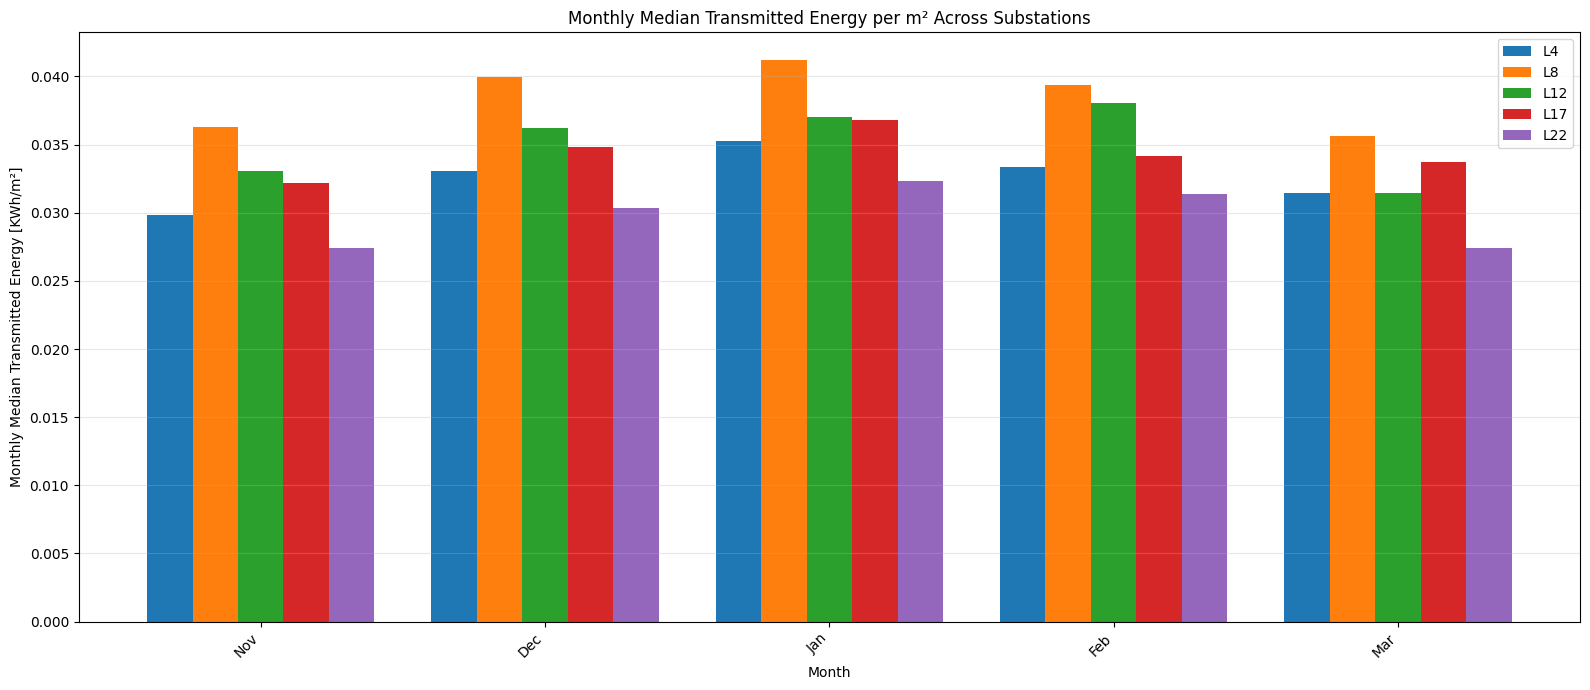

In [225]:
substations_heated_area={'L4': 9134.96, 'L8': 3800.69, 'L12': 4170.98, 'L17': 9128.1, 'L22': 5103.59}


fig, ax = data.plot_monthly_median_energy_comparison(
    substations=list(substations_heated_area.keys()),
    areas=list(substations_heated_area.values()),  # m² for each substation
    interpolate='model',
    handle_outliers=True,
    handle_outliers_contamination=0.005,
    verbose=True,
    figsize=(16, 7)
)
plt.show()

In [250]:
df_desc = data.describe_substations(
    substations=list(substations_heated_area.keys()),
    areas=list(substations_heated_area.values()),  # m² for each substation
    interpolate='model',
    handle_outliers=True,
    handle_outliers_contamination=0.005,
    verbose=True
)

Processing L4...
Processing L8...
Filtered L12, L22, and L8 data to only include timestamps from October 8th, 2021 onwards due to data quality issues before that date.
Processing L12...
Filtered L12, L22, and L8 data to only include timestamps from October 8th, 2021 onwards due to data quality issues before that date.
Processing L17...
Processing L22...
Filtered L12, L22, and L8 data to only include timestamps from October 8th, 2021 onwards due to data quality issues before that date.


In [251]:
def fmt(x):
    return f"{x:.1f}" if isinstance(x, (int, float, np.floating, np.integer)) else x

df_desc.style.format(fmt).background_gradient(
    cmap="viridis",
    subset=df_desc.select_dtypes(include="number").columns
)

,L4,L8,L12,L17,L22
First datetime,2019-11-18 06:00,2021-11-18 06:00,2021-11-18 06:00,2019-11-18 06:00,2021-11-18 06:00
Last datetime,2025-03-31 22:00,2025-03-31 22:00,2025-03-31 22:00,2025-03-31 22:00,2025-03-31 22:00
Total datapoints,19302.0,12860.0,12860.0,19302.0,12860.0
Number of seasons,6.0,4.0,4.0,6.0,4.0
Heated area [m²],9135.0,3800.7,4171.0,9128.1,5103.6
Median total energy transmitted per season [kWh],595202.3,309574.2,305868.2,649891.3,311316.3
Mean total energy transmitted per season [kWh],563404.3,308931.8,310469.8,642935.0,321323.6
Std total energy transmitted per season [kWh],88499.1,13951.7,23462.0,43950.9,36184.7
Normalized (per m2 of heating area) median total energy transmitted per season [kWh],65.2,81.5,73.3,71.2,61.0
Total energy transmitted [kWh],3380425.6,1235727.4,1241879.0,3857610.0,1285294.4


## 2. Forecasting Module

Functions for heat load forecasting

In [264]:
models, oof_pred, metrics, feat_cols, work, best_last, y_true, pred_final = forecasting.train_xgb_qizm_walkforward(
    df,
    season_col="season",
    n_lags=24,                       # qizm lags 1..24
    add_temp_lags=[1,2,3,6,12,24],    # only these lags for the other columns
    temp_lag_cols=["t_amb","t_sup_prim","t_ret_prim","t_sup_sec","t_ret_sec","temp"],
    base_features=None,
    require_complete_cases=True,
    two_stage=True,
    on_col="heating_on",
    clf_threshold=0.5,
    optimize_last_fold=False,
    optimize_metric="MAE",      # or "RMSE" / "MASE" / "sMAPE"
    max_evals=50,
    val_frac_last_fold=0.2,
)

print(metrics)

Season 2 | MAE=35.440, RMSE=89.232, R2=0.716, MASE=0.751, sMAPE=20.64% | pred=0.013 ms/row | ON-rate=0.46
Season 3 | MAE=29.010, RMSE=62.736, R2=0.850, MASE=0.566, sMAPE=17.00% | pred=0.014 ms/row | ON-rate=0.67
Season 4 | MAE=26.175, RMSE=59.667, R2=0.838, MASE=0.494, sMAPE=15.66% | pred=0.013 ms/row | ON-rate=0.65
Season 5 | MAE=26.171, RMSE=57.092, R2=0.857, MASE=0.491, sMAPE=16.61% | pred=0.012 ms/row | ON-rate=0.63
Season 6 | MAE=21.211, RMSE=49.032, R2=0.901, MASE=0.396, sMAPE=12.10% | pred=0.011 ms/row | ON-rate=0.66
   test_season    train_seasons  n_train  n_test        MAE       RMSE  \
0            2              [1]     3209    3209  35.440146  89.231703   
1            3           [1, 2]     6418    3209  29.010109  62.735882   
2            4        [1, 2, 3]     9627    3209  26.174725  59.666884   
3            5     [1, 2, 3, 4]    12836    3233  26.170863  57.092137   
4            6  [1, 2, 3, 4, 5]    16069    3208  21.210697  49.032466   

         R2      MASE    

In [260]:
summary = forecasting.summarize_walkforward_results(
    df=df,
    oof_pred=oof_pred,
    season_col="season",
    target_col="qizm",
)

print(summary)

  Metric  Macro Mean  Macro Std  Micro (Global OOS)
0    MAE   31.807929   6.899401           31.805616
1   RMSE   62.280512  12.806318           63.574443
2     R2    0.839662   0.056219            0.839391
3   MASE    0.580071   0.119075            0.581019
4  sMAPE   87.520780  16.361537           87.513843


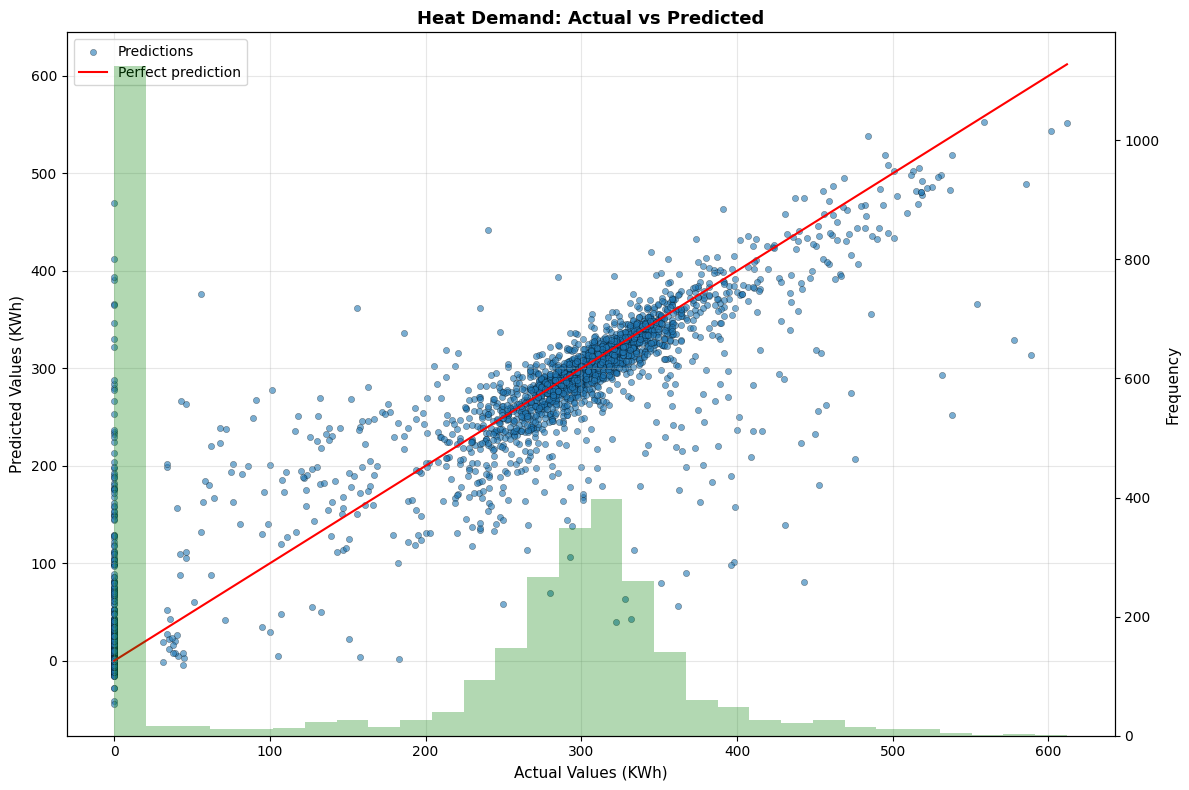

In [258]:
# After training your model and getting predictions
fig, ax, ax2 = forecasting.plot_actual_vs_predicted(
    y_true=y_true,
    pred_final=pred_final,
    figsize=(12, 8),
    title="Heat Demand: Actual vs Predicted",
    bins=40,
    alpha_hist=0.25
)
plt.show()

Although the available data constitute a time-ordered series, the forecasting task was formulated as a supervised regression problem rather than a classical time-series forecasting problem. This decision is justified by the operational characteristics of DHS. Heat demand in such systems is primarily driven by exogenous weather conditions, the current thermohydraulic state of the network, and operator control decisions, which are highly aligned with daily cycles. Consequently, the next-hour transmitted energy (qizmt+1) can be modeled as a function of system variables and past demand and operational parameters (primary and secondary circuit temperatures).

The underlying data-generating process can be expressed conceptually as:

qizmt+1 = f(qizmt, Xt)

where Xt represents exogenous features including ambient temperature, primary and secondary supply/return temperatures, and operational regime indicators. 

The strong daily seasonality observed in the demand signal does not arise from intrinsic seasonal patterns but from deterministic operator scheduling and building occupancy patterns. Therefore, capturing this cyclic behavior through lagged variables (e.g. qizmt−24) and time-of-day encodings is proven sufficient for representing daily structure (Zdravković et al, 2024). The adopted lag window (up to 24 hours) is grounded in the physical and operational characteristics of DHS. The thermal inertia of the network and connected buildings typically operates within intra-day scales, while operator control policies and occupancy patterns follow a strong daily cycle. Therefore, including autoregressive lags covering one full diurnal period allows the model to capture both short-term dynamics (1–3 hours) and daily recurrence effects (24-hour periodicity). This approach is consistent with the thermodynamic time constants and control logic observed in practice and validated with domain experts and plant operators.

The forecasting pipeline therefore consists of constructing autoregressive lag features (e.g. qizmt−1,..,qizmt−24), physics-informed features such as temperature differentials (ΔT=Tsup−Tret), and calendar or regime indicators (hour of day, heating_on). Hour of a day will be cyclic encoded and represented as sin(hour of day) and cos(hour of day).

Despite not employing a classical time-series model, temporal integrity is strictly preserved. Data are split using walk-forward validation to prevent information leakage, and only past information is used when constructing lagged predictors.

### Timing

The experiment involves also collecting timing metrics that measure the computational performance of the walk-forward forecasting process.

The following metrics is collected:
- Optimization Times (only for last fold): Time (in seconds) spent performing Bayesian hyperparameter optimization for the classifier and regressor (separately) using Hyperopt, with added fitting time. This includes all the trial evaluations (up to max_evals iterations) to find the best hyperparameters.
- Average prediction time per sample in milliseconds = (pred_time_total_s / n_test) * 1000. This is useful for understanding real-time deployment performance.

All times use time.perf_counter() for accurate wall-clock measurements.

## Model evaluation

Model performance was evaluated using season-wise walk-forward validation, producing both macro-averaged (season-balanced) and micro-aggregated (global) performance indicators. This approach facilitates assessment of both cross-season robustness and overall operational forecasting accuracy. Such an approach to model evaluation enables observation of performance trends and provides empirical evidence regarding whether adding additional seasons yields diminishing performance gains, thereby uncovering learning saturation.

The macro-averaged metrics represent the arithmetic mean of performance scores computed independently for each heating season. This formulation assigns equal importance to each season regardless of its duration, thereby preventing longer/harsher or shorter/milder winters from disproportionately influencing the evaluation. Standard deviation, as an associated metrics, quantifies inter-season variability and provides a measure of model stability under differing meteorological and operational conditions. Low dispersion across seasons indicates that the model generalizes consistently across heterogeneous heating regimes.

On another hand, the micro (global out-of-sample) metrics are computed by jointly evaluating all walk-forward predictions across seasons. This approach reflects the expected real-world performance of the forecasting system under continuous deployment, as it weights errors proportionally to the number of operational hours. Consequently, micro metrics provide an estimate of aggregate forecasting accuracy over the full multi-season horizon.

The inclusion of multiple error measures allows comprehensive assessment of predictive behavior:

- MAE (Mean Absolute Error) quantifies average operational deviation in physical units (KWh), directly interpretable from an energy management perspective.
- RMSE (Root Mean Squared Error) penalizes large deviations more strongly, reflecting sensitivity to extreme forecasting errors.
- R² (Coefficient of Determination) measures the proportion of variance in transmitted energy explained by the model, indicating how well thermodynamic and operational patterns are captured.
- MASE (Mean Absolute Scaled Error) evaluates performance relative to a naïve persistence benchmark, enabling scale-independent comparison across seasons.
- sMAPE (Symmetric Mean Absolute Percentage Error) provides a relative error measure robust to seasonal demand magnitude variation. It is important to highlight that sMAPE formulation can become unstable when both observed and predicted values approach zero. To address this issue, we implement a numerically robust formulation of sMAPE in which divisions by zero are explicitly avoided, and observations with both true and predicted values equal to zero contribute zero error. Furthermore, we explicitly report MASE as a primary scale-free metric, since it compares model performance against a naïve persistence benchmark and remains well-defined under intermittent conditions. This ensures that improvements over baseline behaviour are properly quantified even when demand is frequently zero.

## Staged design

The proposed forecasting architecture adopts a two-stage design in order to explicitly model the operational regime structure of district heating systems. In the first stage, a binary classifier predicts whether the heating plant will be in operation in the next hour. In the second stage, a regression model estimates the transmitted energy conditional on the plant being active. The final forecast is obtained by combining the two components: the predicted heat demand is set to zero when the classifier predicts an OFF state, and otherwise equals the regression output.

The proposed architecture decomposes next-hour heat demand forecasting into two conditional subproblems. Let $y_{t+1}$ denote transmitted energy and $z_{t+1} \in \{0,1\}$ denote the operational state (plant OFF/ON). In the first stage, a Gradient Boosting classifier estimates

$\hat{z}_{t+1} = \mathbb{P}\left(z_{t+1}=1 \mid \mathbf{x}_t\right)$

where Xt contains only information available at time t (lagged demand, thermal state variables, weather inputs and regime indicators). In the second stage, a regression model estimates

$\hat{y}_{t+1}^{reg} = f(\mathbf{x}_t)$

using the same feature set and trained to predict the continuous demand magnitude. The final forecast is defined as

$\hat{y}_{t+1} = \begin{cases} 0, & \text{if } \hat{z}_{t+1}=0, \\ \hat{y}_{t+1}^{reg}, & \text{if } \hat{z}_{t+1}=1. \end{cases}$

Thus, the classifier output does not enter the regression model as an input variable; instead, it functions as a gating mechanism that enforces the physical constraint of zero demand during OFF periods. The dependency between stages is therefore sequential rather than bidirectional, avoiding circular information flow.

Regarding error propagation, two types of errors are possible: (i) false negatives, where an ON period is classified as OFF, resulting in a zero prediction; and (ii) false positives, where an OFF period is classified as ON, allowing the regression output to pass through. These effects are explicitly captured in the walk-forward evaluation, where the final performance metrics are computed on the combined output of both stages. Importantly, this decomposition reduces bias associated with zero-inflated demand distributions and improves stability during regime transitions, while preserving temporal causality (no future information is used in either stage).

This decomposition reflects the physical and operational reality of district heating systems, where the demand is inherently intermittent and governed by operator decisions. By separating regime detection (on/off) from magnitude estimation, the model reduces bias introduced by zero-inflated observations, improves stability during transition periods, and better preserves the structural intermittency of the heat demand signal.



## 3. XAI Module

Functions for model explainability and interpretation

In [288]:
seasons = list(models.keys())
feature_importances = {}
for i in seasons:
    mdl = models[i]['reg']
    fi = forecasting.get_feature_importances(mdl,
                                             feat_cols,
                                             importance_type='gain',
                                             top_n=10
                                             )
    feature_importances[i] = fi

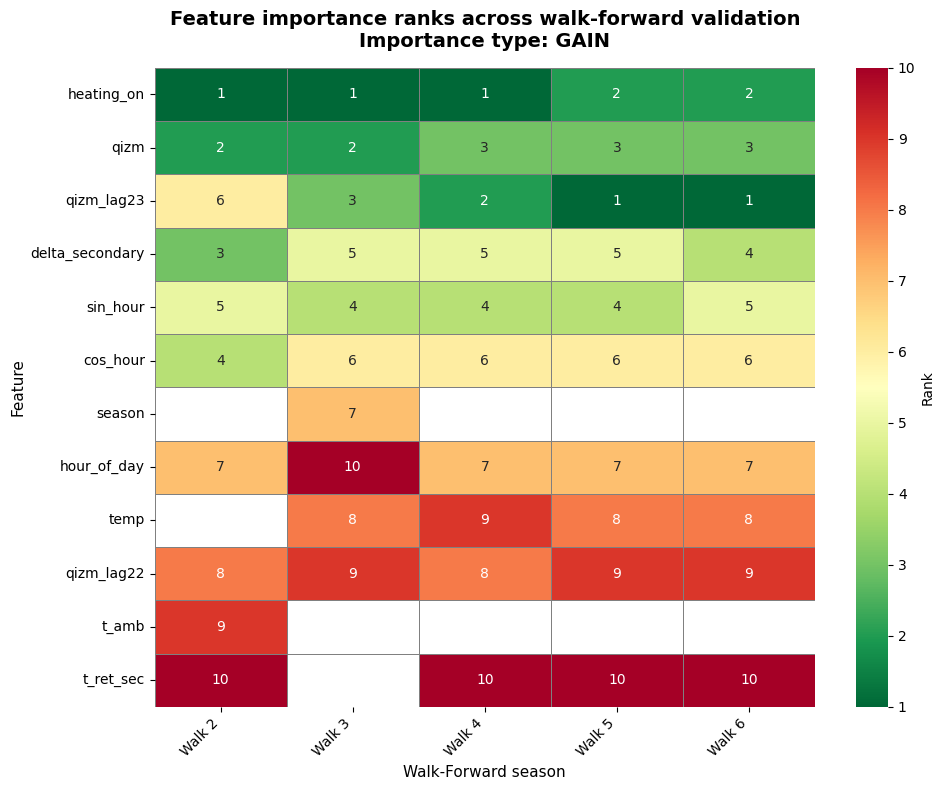

In [289]:
# Plot heatmap
fig, ax = forecasting.plot_feature_rank_heatmap(
    feature_importances, 
    importance_type='gain'
)
plt.show()

# 4. Full analysis

In [290]:
# Test data module functions here

substations=['L4', 'L8', 'L12', 'L17', 'L22']

for substation in substations:
    df=data.get_scada_data(substation,
                 True,
                 True,
                 interpolate='model',
                 handle_outliers=True,
                 handle_outliers_contamination=0.005
    )
    
    models, oof_pred, metrics, feat_cols, work, best_last, y_true, pred_final = forecasting.train_xgb_qizm_walkforward(
        df,
        season_col="season",
        n_lags=24,                       # qizm lags 1..24
        add_temp_lags=[1,2,3,6,12,24],    # only these lags for the other columns
        temp_lag_cols=["t_amb","t_sup_prim","t_ret_prim","t_sup_sec","t_ret_sec","temp"],
        base_features=None,
        require_complete_cases=True,
        two_stage=True,
        on_col="heating_on",
        clf_threshold=0.5,
        optimize_last_fold=True,
        optimize_metric="MAE",      # or "RMSE" / "MASE" / "sMAPE"
        max_evals=50,
        val_frac_last_fold=0.2,
    )
    print(metrics)

    summary = forecasting.summarize_walkforward_results(
        df=df,
        oof_pred=oof_pred,
        season_col="season",
        target_col="qizm",
    )
    print(summary)

    # After training your model and getting predictions
    fig, ax, ax2 = forecasting.plot_actual_vs_predicted(
        y_true=y_true,
        pred_final=pred_final,
        figsize=(12, 8),
        title="Heat Demand: Actual vs Predicted",
        bins=40,
        alpha_hist=0.25
    )
    
    plt.show()

KeyboardInterrupt: 

The walk-forward results indicate consistently high one-step forecasting performance across all substations, with differences driven primarily by the local demand magnitude (due to different heated areas). For the optimized last walk, the models achieve R^2 ≈ 0.90–0.92 with sMAPE ≈ 10.8%–12.4% and MASE<0.46 for all sites, demonstrating clear improvement over a naïve persistence baseline. 

Among substations, the comparison of forecasting performance rely on scale-independent metrics, namely MASE, sMAPE, and R^2., rather than on MAE or RMSE, which are inherently dependent on load magnitude. In this respect, L12 and L22 exhibit the strongest relative performance, with MASE values in the range of approximately 0.37–0.38 and sMAPE around 10.8–11.3%, indicating the largest improvement over the naïve persistence benchmark and the lowest relative error. L8 shows comparable performance (MASE ≈ 0.41; sMAPE ≈ 11.4%), while L4 and L17 demonstrate slightly higher MASE (≈ 0.38–0.45) and sMAPE (≈ 11.3–12.4%), suggesting comparatively greater relative forecasting difficulty. Importantly, all substations maintain consistently high explanatory power, with R^2 values around 0.90, indicating that the temporal structure and variability of the heat demand signal are well captured across sites.

Season-level aggregation further supports robustness. The macro means (season-balanced) are very close to the micro (global OOS) metrics for each site, indicating that performance is not disproportionately driven by a single season and that the walk-forward strategy produces a stable estimate of generalization. However, the macro standard deviations are non-negligible, especially for MAE/RMSE (e.g., L4 MAE std ≈ 4.74; L17 MAE std ≈ 3.08), which is expected under changing winter severity, operational control regimes, and intermittent heating schedules across seasons. Still, the macro std for R^2 remains low (≈0.02–0.06), reinforcing that the model preserves explanatory power even when absolute errors fluctuate seasonally.

It is very important to highlight that the analysis of metrics in consecutive walks, under the same conditions (without hyperoptimization of parameters for the last walk) shows learning saturation after the third walk, suggesting that 2 seasons of data is sufficient for training the accurate and robust one-step forecasting model.

From a deployment perspective, the staged modeling remains computationally practical. Even with Bayesian hyperparameter optimization applied in the last walk, total training+optimization time is on the order of a few minutes per substation (regressor ≈ 174–269 s; classifier ≈ 48–69 s), while inference is extremely fast (≈ 0.010–0.013 ms per row). This runtime profile supports near-real-time operation and enables periodic re-training (for example, per season or per month) without any operational burden. 

Overall, the results suggest that the proposed walk-forward evaluation and staged on/off gating provide (i) strong predictive accuracy beyond naïve baselines (MASE consistently < 0.5), (ii) stable generalization across multiple heating seasons (macro ≈ micro; modest macro variability), and (iii) real-time feasible inference.